---
date: last-modified
---

# Plotting polar cloud variables from PREFIRE data

## Summary

This notebook shows how to retrieve and plot cloud values for the polar region, from [Polar Radiant Energy in the Far-InfraRed Experiment (PREFIRE)](https://asdc.larc.nasa.gov/project/PREFIRE) data.

## Prerequisites

- cartopy
- earthaccess
- matplotlib
- netCDF4
- numpy

### Notebook Authors / Affiliation

Alex Radkevich / Atmospheric Science Data Center (ASDC)

# Installing libraries

In [46]:
# Install external dependencies
#!pip install -qq python-cmr # these are installed in OPENSCAPES, in other environments may need to be installed first
#!pip install -qq gnss_lib_py # this might be needed to work with GPS time

# Importing libraries

In [47]:
from datetime import datetime  # needed to work with time in plotting time series
import getpass
import requests

import cartopy.crs as ccrs
import earthaccess  # needed to discover and download TEMPO data
import matplotlib.pyplot as plt  # needed to plot the resulting time series
import netCDF4 as nc  # needed to read TEMPO data
import numpy as np


# function to read data

In [48]:
def read_PREFIRE_2B_CLD(fn):
    try:
        with nc.Dataset(fn) as ds:
            geo = ds.groups["Geometry"]
            var = geo.variables["ctime"]
            ctime = np.ma.getdata(var[:])

            var = geo.variables["ctime_minus_UTC"]
            ctime_minus_UTC = np.ma.getdata(var[:])

            var = geo.variables["latitude"]
            lat = np.ma.getdata(var[:])

            var = geo.variables["longitude"]
            lon = np.ma.getdata(var[:])

            var = geo.variables["time_UTC_values"]
            time_UTC = np.ma.getdata(var[:])

            Cld = ds.groups["Cld"]
            var = Cld.variables["cld_qc_bitflags"]
            bitQF = np.ma.getdata(var[:])

            var = Cld.variables["cloud_d_eff"]
            cloud_d_eff = np.ma.getdata(var[:])
            fv_cloud_d_eff = var.get_fill_value()

            var = Cld.variables["cloud_tau"]
            cloud_tau = np.ma.getdata(var[:])
            fv_cloud_tau = var.get_fill_value()

            var = Cld.variables["cloudtop_pressure"]
            cloudtop_pressure = np.ma.getdata(var[:])
            fv_cloudtop_pressure = var.get_fill_value()

    except Exception:
        ctime = 0.0
        ctime_minus_UTC = 0.0
        lat = 0.0
        lon = 0.0
        time_UTC = 0.0
        bitQF = 0.0
        cloud_d_eff = 0.0
        fv_cloud_d_eff = 0.0
        cloud_tau = 0.0
        fv_cloud_tau = 0.0
        cloudtop_pressure = 0.0
        fv_cloudtop_pressure = 0.0

    return (
        ctime,
        ctime_minus_UTC,
        lat,
        lon,
        time_UTC,
        bitQF,
        cloud_d_eff,
        fv_cloud_d_eff,
        cloud_tau,
        fv_cloud_tau,
        cloudtop_pressure,
        fv_cloudtop_pressure,
    )

## Using earthaccess library
see

https://earthaccess.readthedocs.io/en/latest/

for more details on this library

### login to Earthdata via earthaccess

In [49]:
# User needs to create an account at https://www.earthdata.nasa.gov/
# Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

### define a function to get collection ID from its short_name and version

In [50]:
def get_collectionID_earthaccess(short_name, version):
    collectionID = "-1"

    results = earthaccess.search_datasets(short_name=short_name, version=version)

    if len(results) == 1:
        collectionID = results[0]["meta"]["concept-id"]
    else:
        raise Exception("Specify valid collection")

    return collectionID

In [51]:
short_name = "PREFIRE_SAT2_2B-CLD"
version = "R01"
collectionID = get_collectionID_earthaccess(short_name, version)
print(
    f"collectionID for collection short_name {short_name} and version {version} is {collectionID}"
)

collectionID for collection short_name PREFIRE_SAT2_2B-CLD and version R01 is C3499264827-LARC_CLOUD


### getting collection ID

# Search for granules using earthaccess library
specify timeframe and/or boundingbox of interest

In [52]:
short_name = "PREFIRE_SAT2_2B-CLD"  # collection name
version = "R01"  # version of the collection

yyyy = 2024
mm = 9
dd = 1

date_start = str("%4.4i-%2.2i-%2.2i 00:00:00" % (yyyy, mm, dd))
date_end = str("%4.4i-%2.2i-%2.2i 06:00:00" % (yyyy, mm, dd))

results_earthaccess = earthaccess.search_data(
    short_name=short_name,
    version=version,
    # bounding_box: a tuple representing spatial bounds in the form
    # (lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat)
    # where -180 <= lower_left_lon, upper_right_lon < 180,
    #        -90 <= lower_left_lat, upper_right_lat <= 90
    bounding_box=(-180.0, 60.0, 180.0, 90.0),
    temporal=(date_start, date_end),
)
PREFIRE_names = sorted([r["meta"]["native-id"] for r in results_earthaccess])
for name in PREFIRE_names:
    print(name)

PREFIRE_SAT2_2B-CLD_R01_P00_20240831222721_01490.nc
PREFIRE_SAT2_2B-CLD_R01_P00_20240901013749_01492.nc
PREFIRE_SAT2_2B-CLD_R01_P00_20240901031303_01493.nc
PREFIRE_SAT2_2B-CLD_R01_P00_20240901044818_01494.nc


### compare outcome with Earthdata Search results

!["comparison with EDS granules search outcome"](EDS_search_for_granules_05-30-2025_02.png)

# Download granules with earthaccess

## One-by-one

In [53]:
PREFIRE_links = sorted([r.data_links() for r in results_earthaccess])
for link in PREFIRE_links:
    print(link)
    granule = earthaccess.download(link, local_path=".")

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_2B-CLD_R01/2024.08.31/PREFIRE_SAT2_2B-CLD_R01_P00_20240831222721_01490.nc']


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_2B-CLD_R01/2024.09.01/PREFIRE_SAT2_2B-CLD_R01_P00_20240901013749_01492.nc']


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_2B-CLD_R01/2024.09.01/PREFIRE_SAT2_2B-CLD_R01_P00_20240901031303_01493.nc']


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_2B-CLD_R01/2024.09.01/PREFIRE_SAT2_2B-CLD_R01_P00_20240901044818_01494.nc']


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

## All at once

In [54]:
# remove downloaded granules for demonstration
!rm *.nc

In [55]:
granules = earthaccess.download(results_earthaccess, local_path=".")

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

# Plotting variables cloud_d_eff, cloud_tau, cloudtop_pressure

## North Pole

for the South Pole
the two lines need to be changed in the cell below

    1) projection definition:

    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0, globe=None) # North Pole
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None) # South Pole

    2) extent of the plot:

    ax1.set_extent([0., 360., 60., 90.], crs=transform) # North Pole
    ax1.set_extent([0., 360., -90., -60.], crs=transform) # South Pole

# Plot the variables from the original granules

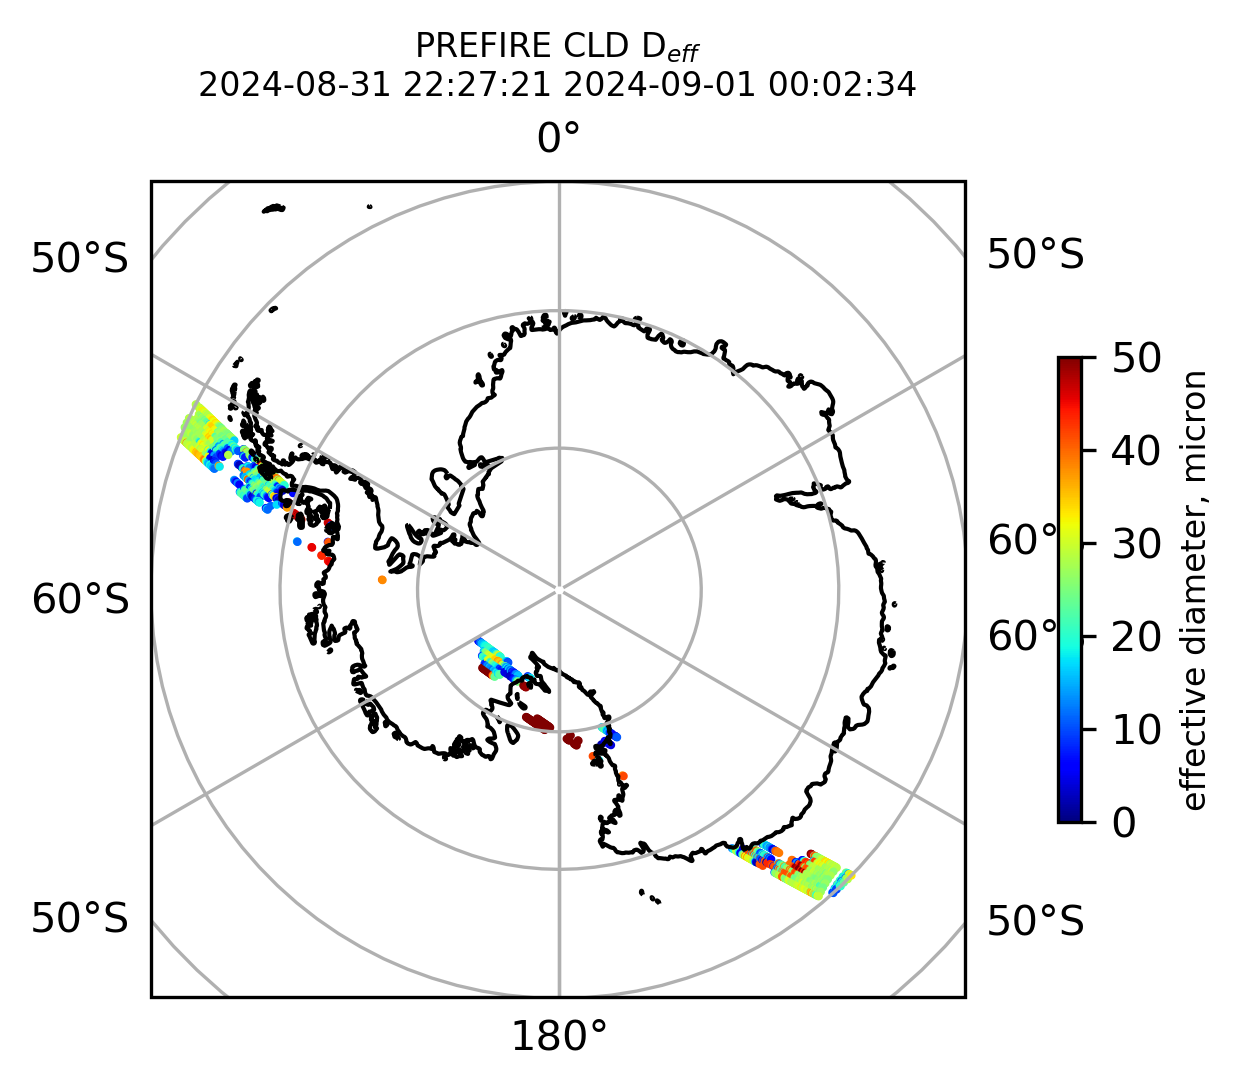

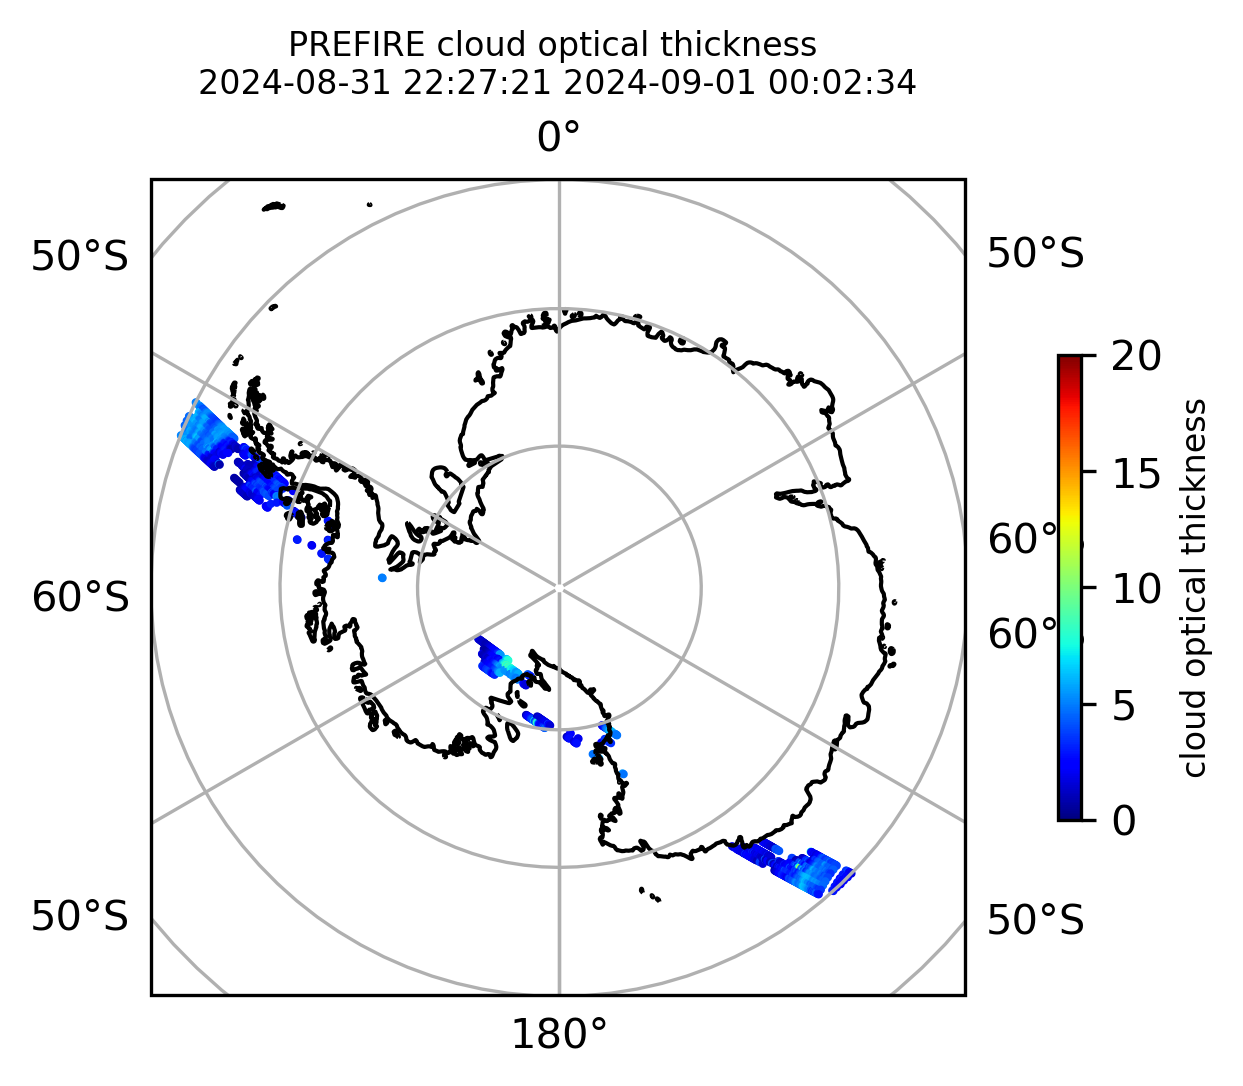

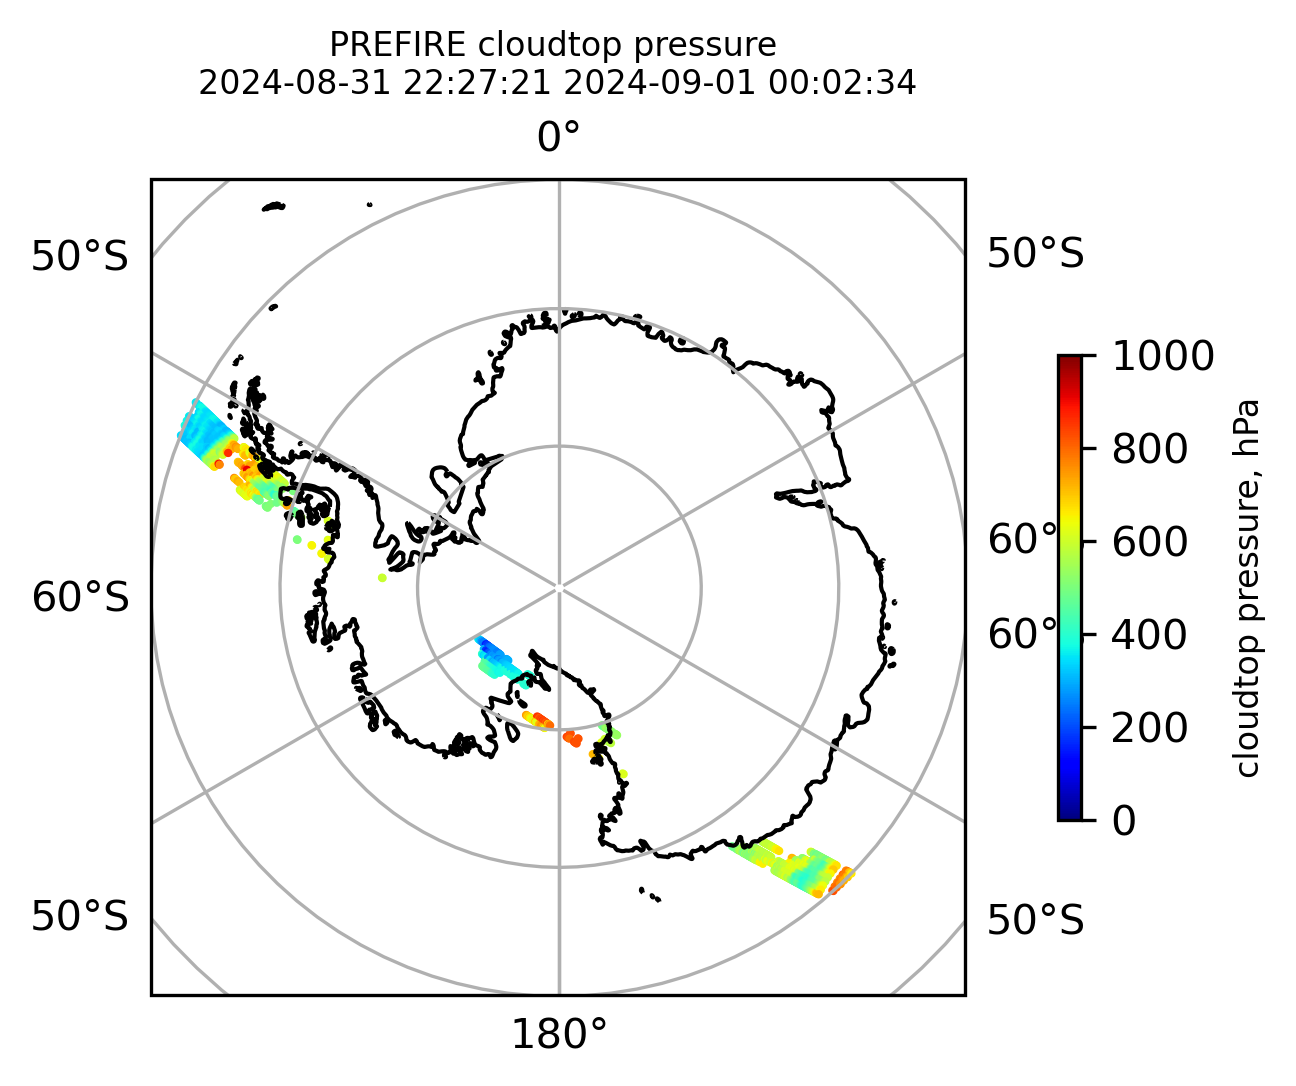

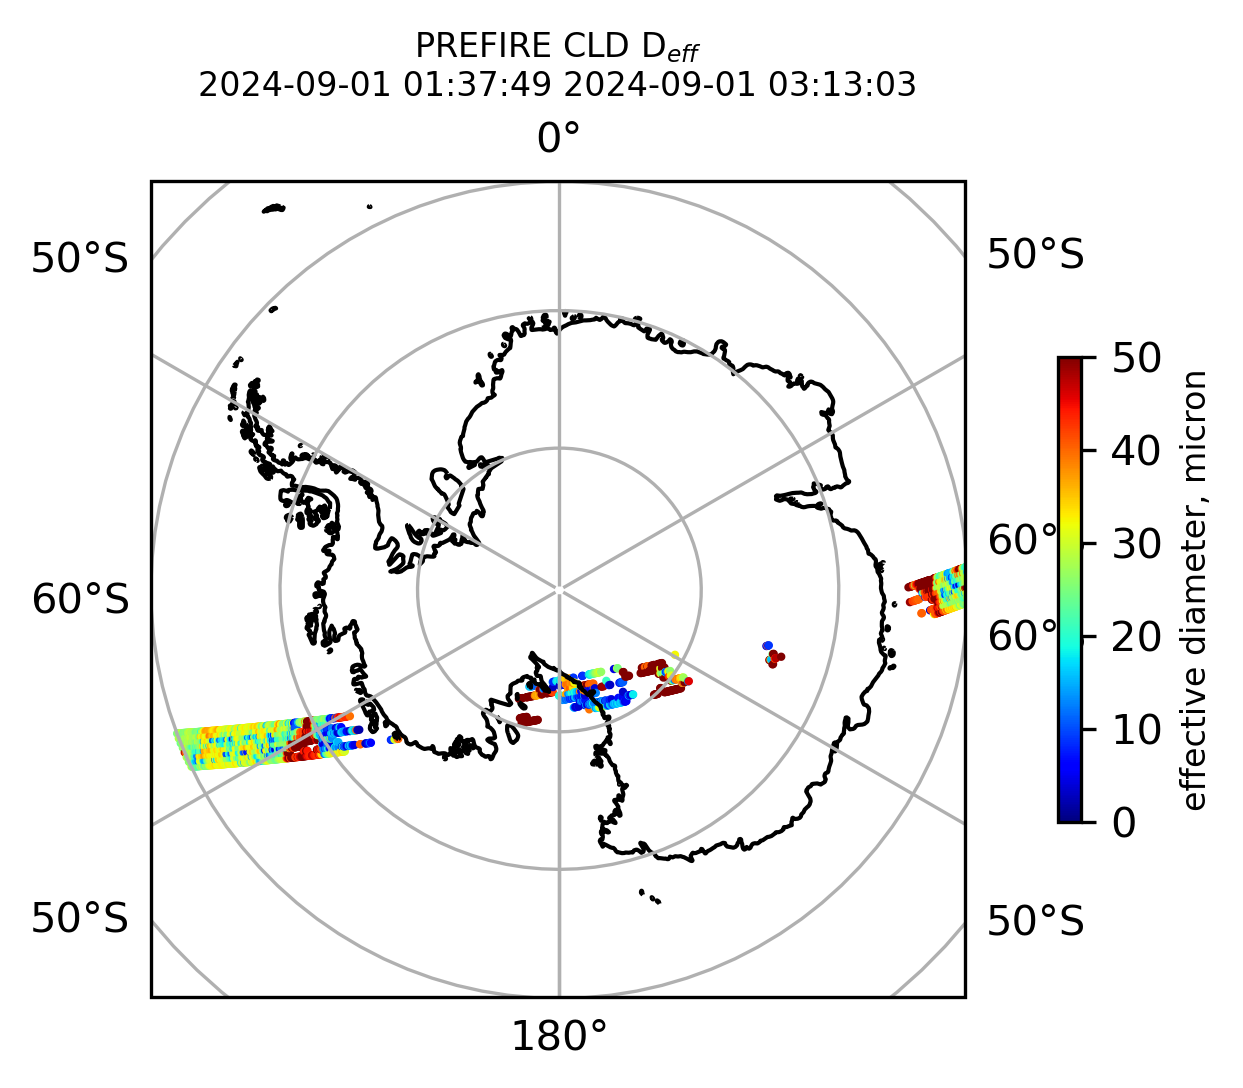

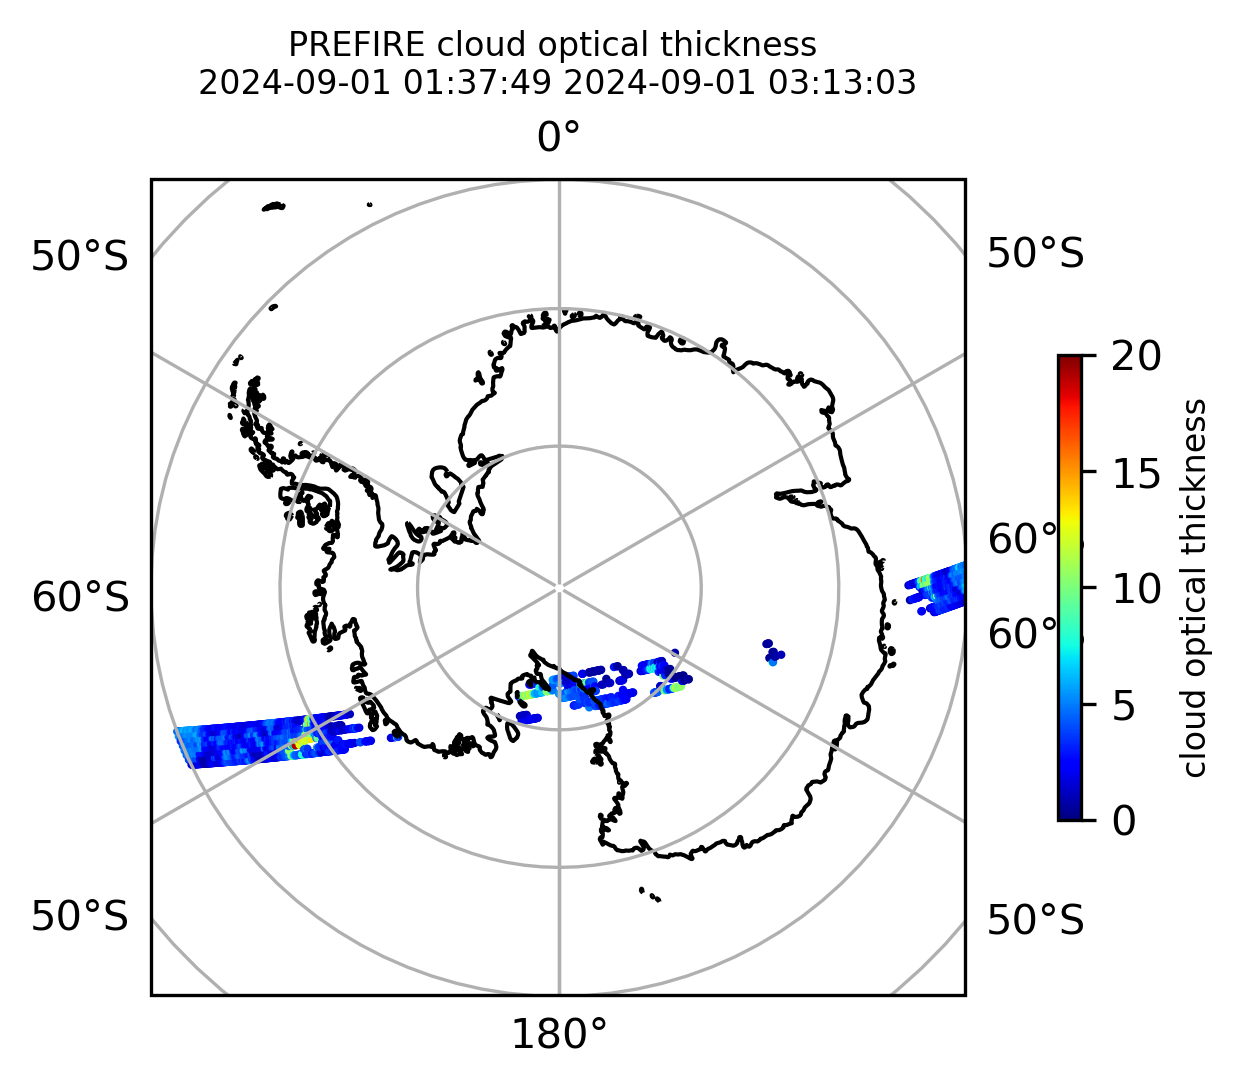

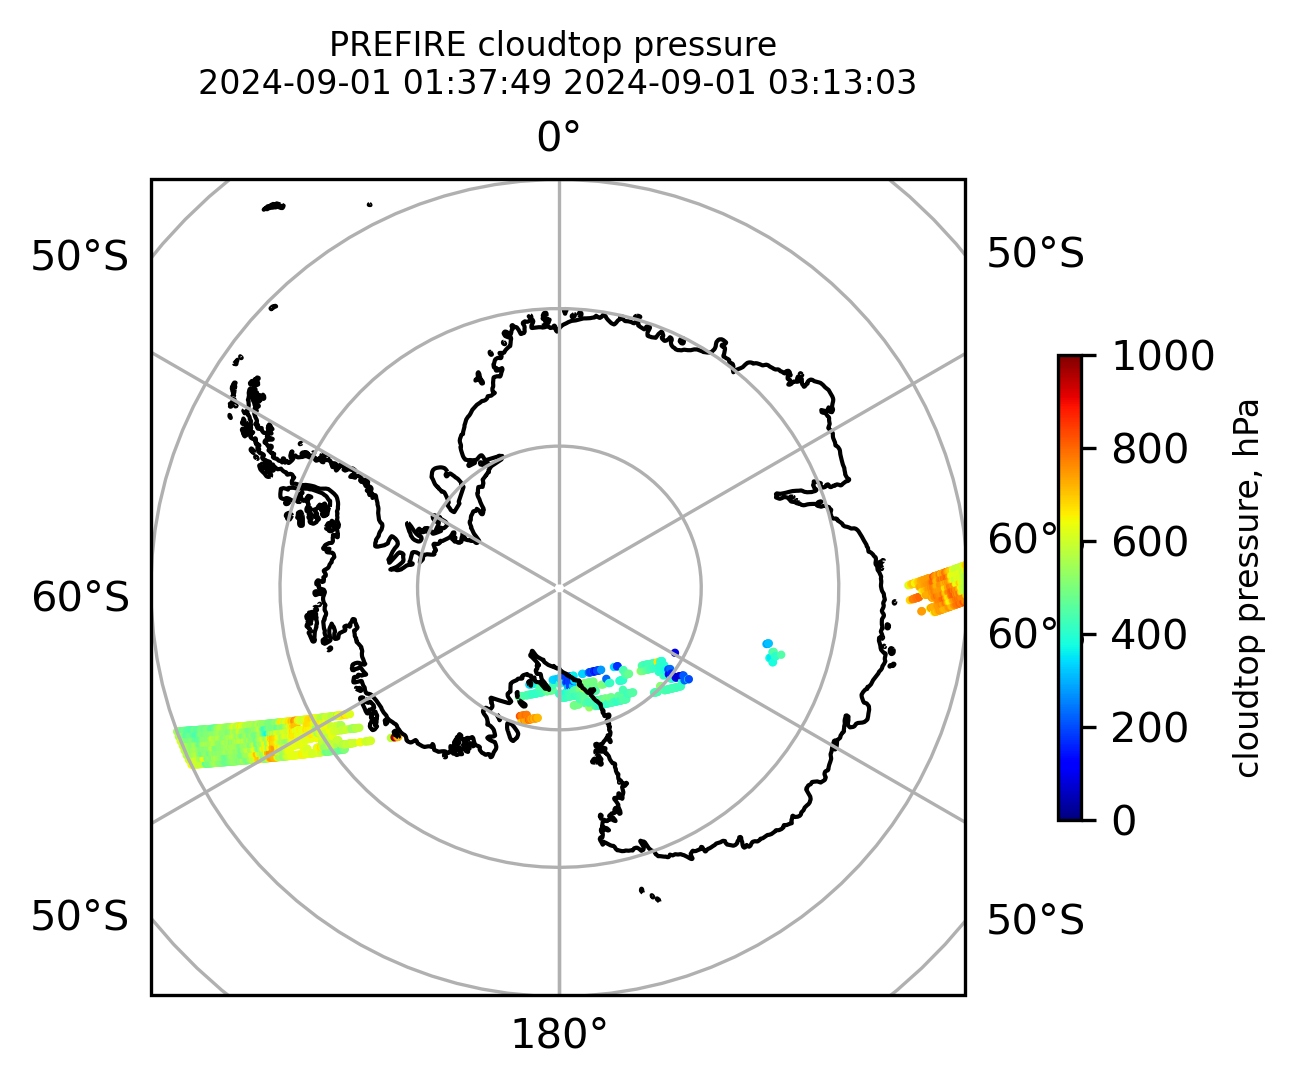

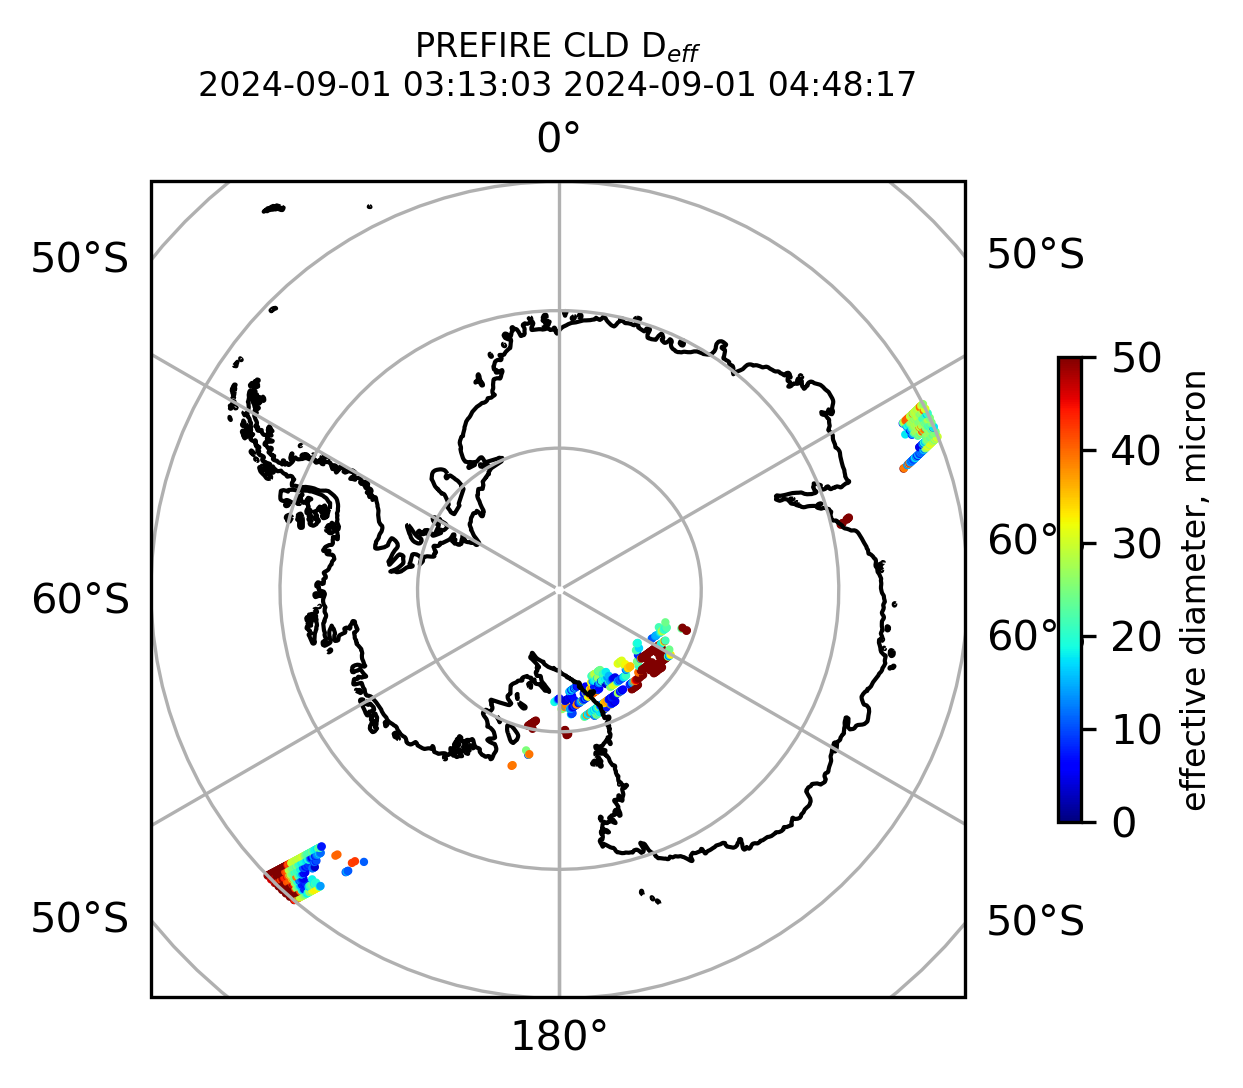

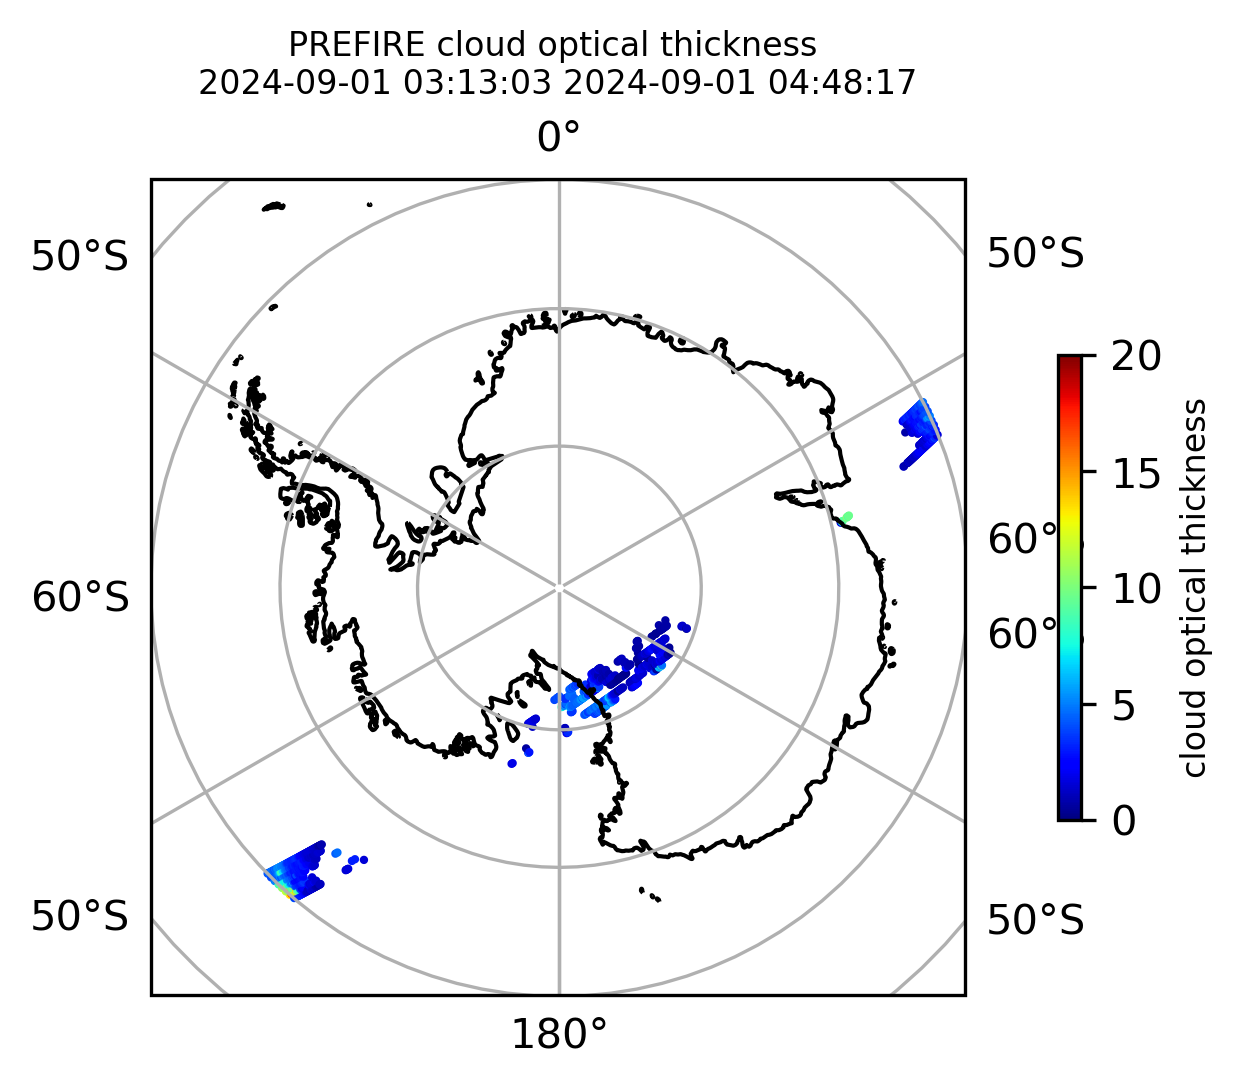

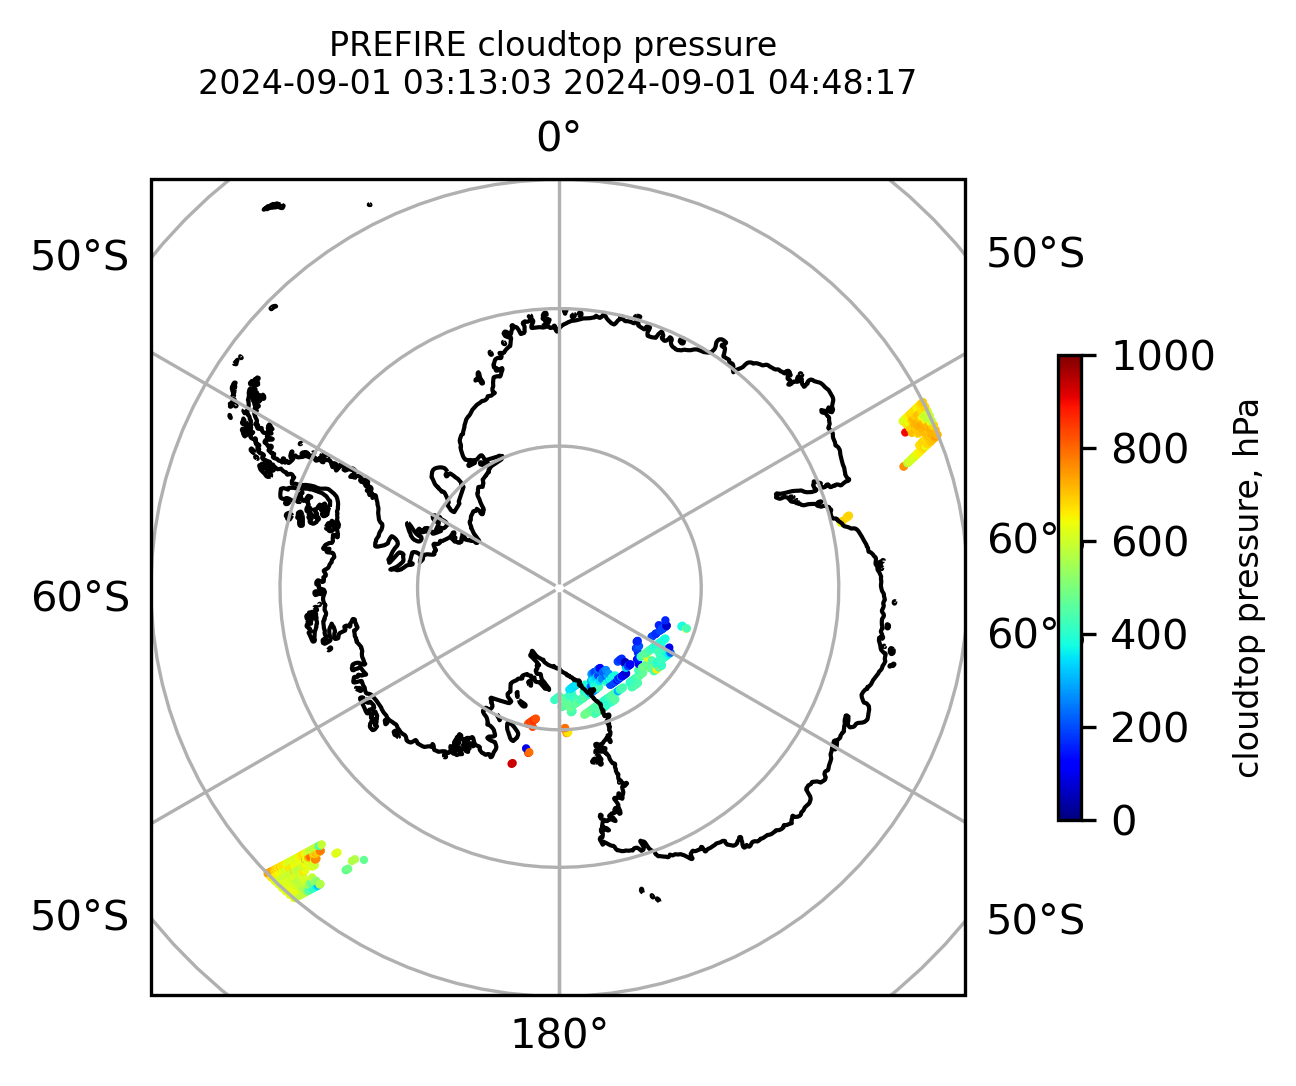

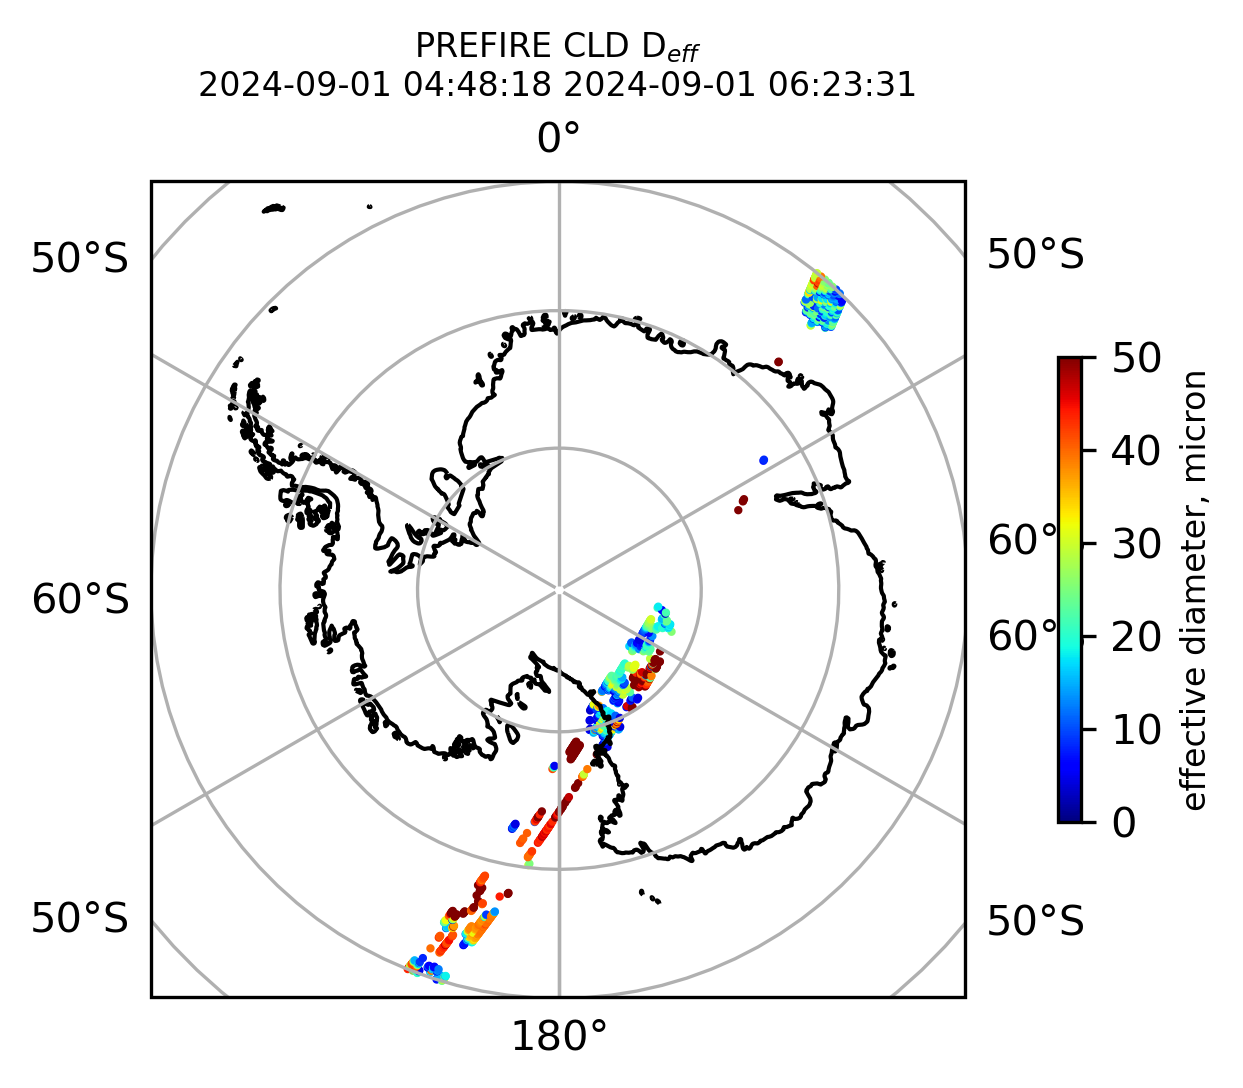

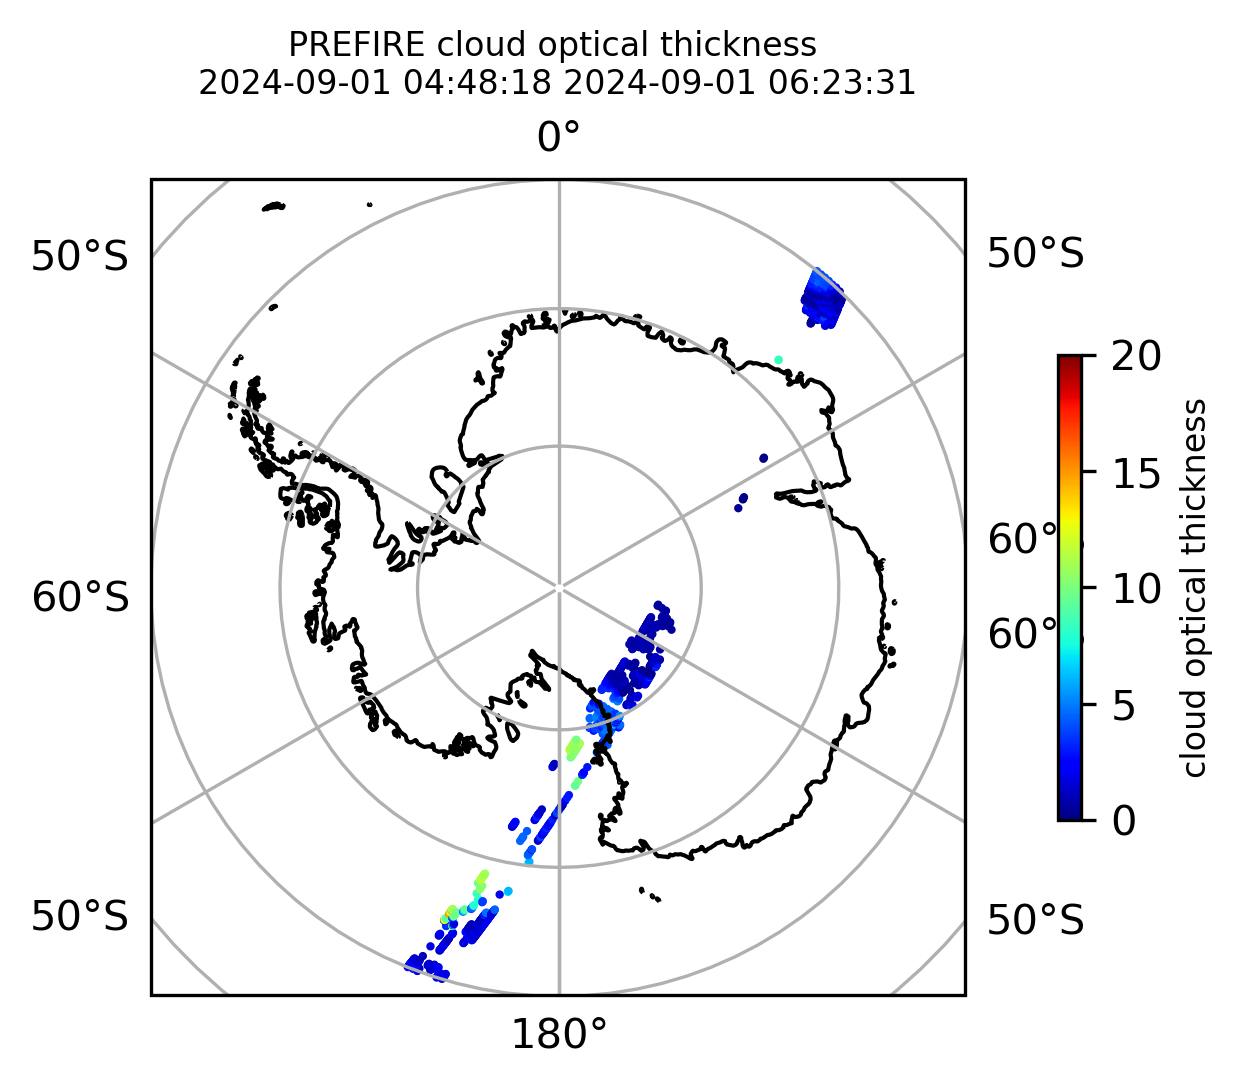

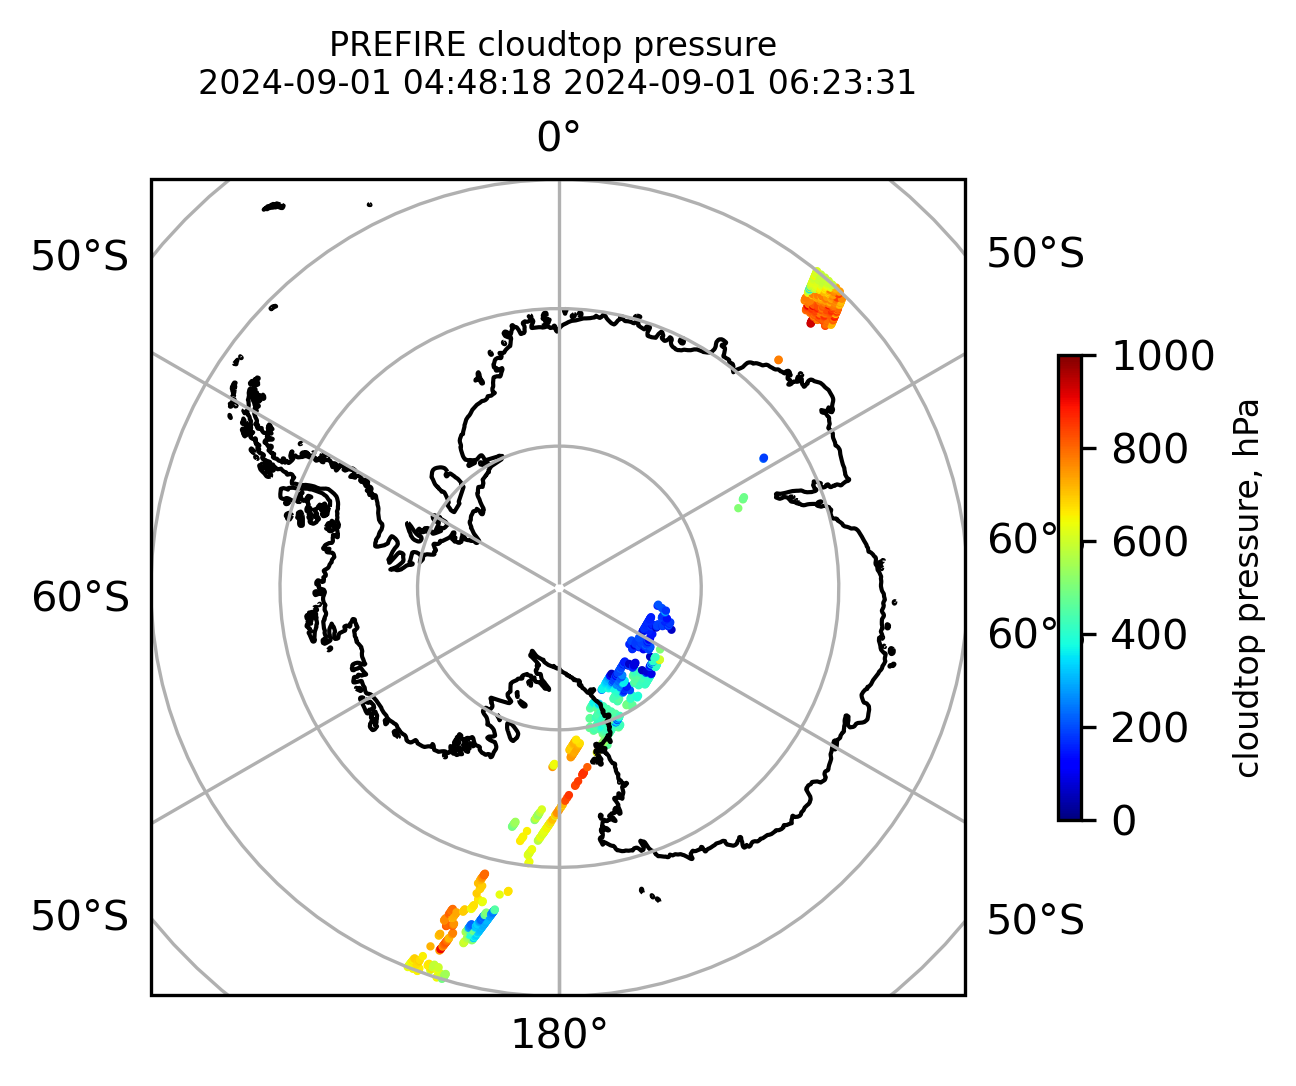

In [56]:
for name in PREFIRE_names:
    (
        ctime_orig,
        ctime_minus_UTC_orig,
        lat_orig,
        lon_orig,
        time_UTC_orig,
        bitQF_orig,
        cloud_d_eff_orig,
        fv_cloud_d_eff_orig,
        cloud_tau_orig,
        fv_cloud_tau_orig,
        cloudtop_pressure_orig,
        fv_cloudtop_pressure_orig,
    ) = read_PREFIRE_2B_CLD(name)

    # find valid beginning and ending times in the slice
    for time in time_UTC_orig[:, :]:
        if time[0] == -9999:
            continue
        beginning_time_array = time
        break

    for time in time_UTC_orig[-1::-1, :]:
        if time[0] == -9999:
            continue
        ending_time_array = time
        break

    beginning_time = f"{beginning_time_array[0]:4d}-{beginning_time_array[1]:02d}-{beginning_time_array[2]:02d} {beginning_time_array[3]:02d}:{beginning_time_array[4]:02d}:{beginning_time_array[5]:02d}"
    ending_time = f"{ending_time_array[0]:4d}-{ending_time_array[1]:02d}-{ending_time_array[2]:02d} {ending_time_array[3]:02d}:{ending_time_array[4]:02d}:{ending_time_array[5]:02d}"
    beginning_time_fn = f"{beginning_time_array[0]:4d}{beginning_time_array[1]:02d}{beginning_time_array[2]:02d}T{beginning_time_array[3]:02d}{beginning_time_array[4]:02d}{beginning_time_array[5]:02d}"
    ending_time_fn = f"{ending_time_array[0]:4d}{ending_time_array[1]:02d}{ending_time_array[2]:02d}T{ending_time_array[3]:02d}{ending_time_array[4]:02d}{ending_time_array[5]:02d}"

    mask_cloud_d_eff = (cloud_d_eff_orig[:, :] != fv_cloud_d_eff) & (bitQF_orig[:, :] == 0)
    mask_cloud_tau = (cloud_tau_orig[:, :] != fv_cloud_tau) & (bitQF_orig[:, :] == 0)
    mask_cloudtop_pressure = (cloudtop_pressure_orig[:, :] != fv_cloudtop_pressure) & (
        bitQF_orig[:, :] == 0
    )

    valid_cloud_d_eff = cloud_d_eff_orig[mask_cloud_d_eff]
    valid_cloud_d_eff_lat = lat_orig[mask_cloud_d_eff]
    valid_cloud_d_eff_lon = lon_orig[mask_cloud_d_eff]

    valid_cloud_tau = cloud_tau_orig[mask_cloud_tau]
    valid_cloud_tau_lat = lat_orig[mask_cloud_tau]
    valid_cloud_tau_lon = lon_orig[mask_cloud_tau]

    valid_cloudtop_pressure = cloudtop_pressure_orig[mask_cloudtop_pressure]
    valid_cloudtop_pressure_lat = lat_orig[mask_cloudtop_pressure]
    valid_cloudtop_pressure_lon = lon_orig[mask_cloudtop_pressure]

    # Plot arrays in orthografic projection
    if len(valid_cloud_d_eff) > 0:
        fig = plt.figure(figsize=(4, 4), dpi=300, facecolor=None)

        proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)
        transform = ccrs.PlateCarree()

        ax1 = fig.add_subplot(111, projection=proj)
        ax1.set_extent([0.0, 360.0, -90.0, -60.0], crs=transform)
        im1 = ax1.scatter(
            valid_cloud_d_eff_lon,
            valid_cloud_d_eff_lat,
            c=valid_cloud_d_eff,
            s=1.0,
            cmap=plt.cm.jet,
            vmin=0.0,
            vmax=50.0,
            transform=transform,
        )
        ax1.coastlines(resolution="50m", color="black", linewidth=1)
        gl = ax1.gridlines(draw_labels=True, dms=True)
        gl.xlabels_top = False
        gl.ylabels_left = False
        cb1 = plt.colorbar(
            im1,
            ticks=[0, 10.0, 20.0, 30.0, 40.0, 50.0],
            fraction=0.025,
            pad=0.1,
            orientation="vertical",
        )
        cb1.set_label("effective diameter, micron", fontsize=8)
        ax1.set_title("PREFIRE CLD D$_{eff}$ \n" + beginning_time + " " + ending_time, fontsize=8)

        plt.savefig(
            "PREFIRE_CLD_D_eff_SP_" + beginning_time_fn + "_" + ending_time_fn + ".png", dpi=600
        )
        plt.show()
        plt.close()
    else:
        print(
            f"there is nothing to plot for cloud effective diameter between {beginning_time} and {ending_time}"
        )

    if len(valid_cloud_tau) > 0:
        fig = plt.figure(figsize=(4, 4), dpi=300, facecolor=None)

        proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)
        transform = ccrs.PlateCarree()

        ax1 = fig.add_subplot(111, projection=proj)
        ax1.set_extent([0.0, 360.0, -90.0, -60.0], crs=transform)
        im1 = ax1.scatter(
            valid_cloud_tau_lon,
            valid_cloud_tau_lat,
            c=valid_cloud_tau,
            s=1.0,
            cmap=plt.cm.jet,
            vmin=0.0,
            vmax=20.0,
            transform=transform,
        )
        ax1.coastlines(resolution="50m", color="black", linewidth=1)
        gl = ax1.gridlines(draw_labels=True, dms=True)
        gl.xlabels_top = False
        gl.ylabels_left = False
        cb1 = plt.colorbar(
            im1, ticks=[0, 5.0, 10.0, 15.0, 20.0], fraction=0.025, pad=0.1, orientation="vertical"
        )
        cb1.set_label("cloud optical thickness", fontsize=8)
        ax1.set_title(
            "PREFIRE cloud optical thickness \n" + beginning_time + " " + ending_time, fontsize=8
        )

        plt.savefig(
            "PREFIRE_CLD_tau_SP_" + beginning_time_fn + "_" + ending_time_fn + ".png", dpi=600
        )
        plt.show()
        plt.close()
    else:
        print(
            f"there is nothing to plot for cloud optical thickness between {beginning_time} and {ending_time}"
        )

    if len(valid_cloudtop_pressure) > 0:
        fig = plt.figure(figsize=(4, 4), dpi=300, facecolor=None)

        proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)
        transform = ccrs.PlateCarree()

        ax1 = fig.add_subplot(111, projection=proj)
        ax1.set_extent([0.0, 360.0, -90.0, -60.0], crs=transform)
        im1 = ax1.scatter(
            valid_cloudtop_pressure_lon,
            valid_cloudtop_pressure_lat,
            c=valid_cloudtop_pressure,
            s=1.0,
            cmap=plt.cm.jet,
            vmin=0.0,
            vmax=1000.0,
            transform=transform,
        )
        ax1.coastlines(resolution="50m", color="black", linewidth=1)
        gl = ax1.gridlines(draw_labels=True, dms=True)
        gl.xlabels_top = False
        gl.ylabels_left = False
        cb1 = plt.colorbar(
            im1,
            ticks=[0, 200.0, 400.0, 600.0, 800.0, 1000.0],
            fraction=0.025,
            pad=0.1,
            orientation="vertical",
        )
        cb1.set_label("cloudtop pressure, hPa", fontsize=8)
        ax1.set_title(
            "PREFIRE cloudtop pressure \n" + beginning_time + " " + ending_time, fontsize=8
        )

        plt.savefig(
            "PREFIRE_CLDTOP_pressure_SP_" + beginning_time_fn + "_" + ending_time_fn + ".png",
            dpi=600,
        )
        plt.show()
        plt.close()
    else:
        print(
            f"there is nothing to plot for cloudtop pressure between {beginning_time} and {ending_time}"
        )